In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
transition_probs = pd.read_csv('transition_probs.csv')

## Build transition matrix

In [3]:
tr_pr = transition_probs.pivot_table(
    index='score_diff_state', 
    columns='next_score_diff_state', 
    values='prob',
    fill_value=0 # replace missing transitions with 0 probability
)

## Plot heatmap

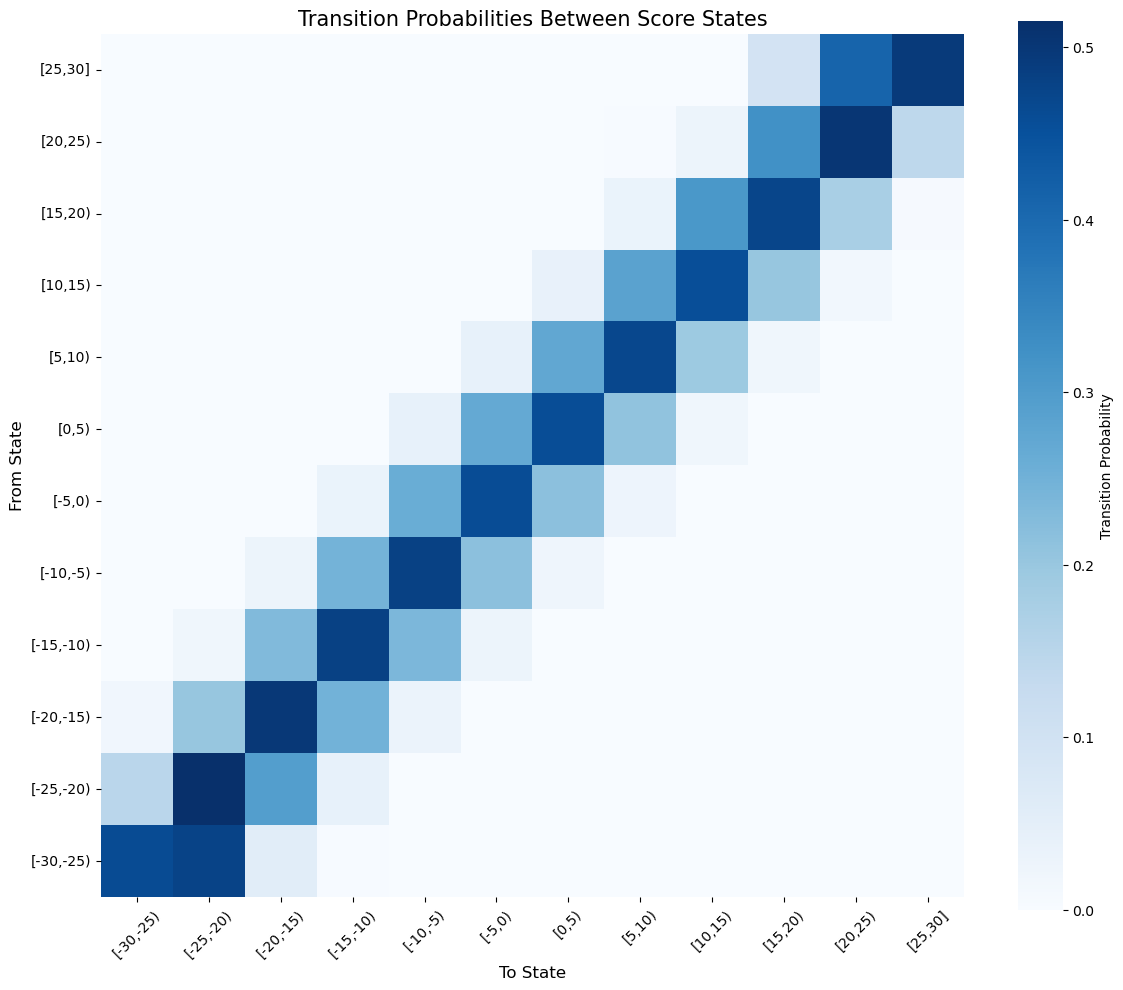

In [4]:
# reorder states
def extract_lower_bound(label):
    return float(label.strip('[]()').split(',')[0])

sorted_states = sorted(tr_pr.index, key=extract_lower_bound)

tr_pr_sorted = tr_pr.loc[sorted_states, sorted_states[::-1]]

plt.figure(figsize=(12, 10))
sns.heatmap(
    tr_pr_sorted, 
    cmap='Blues',
    square=True,
    xticklabels=sorted_states,
    yticklabels=sorted_states[::-1], # deficit (bottom) -> lead (top)
    cbar_kws={'label': 'Transition Probability'}
)

plt.title('Transition Probabilities Between Score States', fontsize=15)
plt.xlabel('To State', fontsize=12)
plt.ylabel('From State', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Simulate Predicted Rubber Band Effect

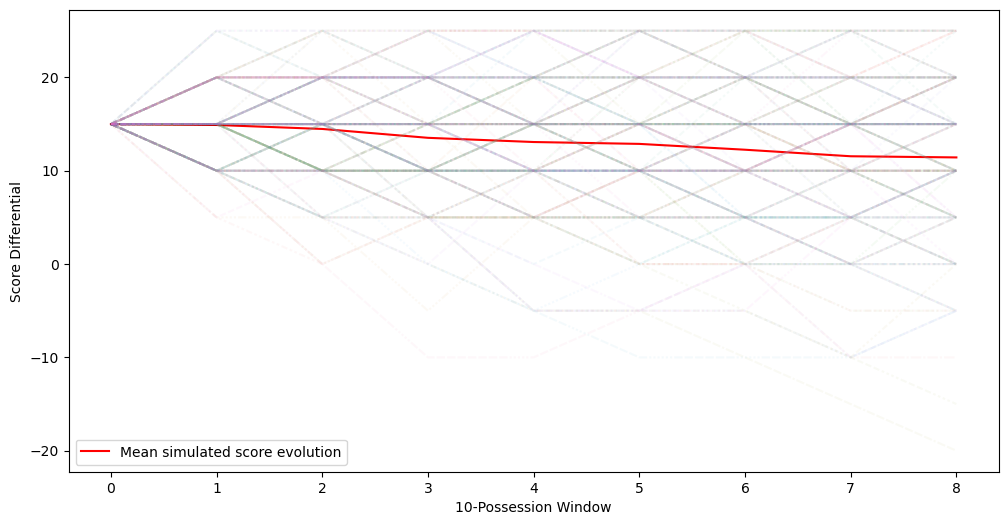

In [5]:
states = tr_pr.index.tolist()
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for i, s in enumerate(states)}

# Convert transition matrix to np array
P = tr_pr.values  # rows sum to 1

# Set initial state (+17)
init_state = '[15,20)'
init_idx = state_to_idx[init_state]

T = 8 # time steps
n_sim = 200 # simulations

rng = np.random.default_rng(seed=42)

# Simulate paths
paths = np.zeros((T + 1, n_sim), dtype=int)
paths[0, :] = init_idx

for t in range(1, T + 1):
    for sim in range(n_sim):
        current_idx = paths[t - 1, sim]
        paths[t, sim] = rng.choice(
            len(states), 
            p=P[current_idx]
        )

# Map categorical states to numeric score differentials
score_values = np.array([extract_lower_bound(s) for s in states])
scores = score_values[paths]

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(T + 1), y=scores.mean(axis=1), color='red', label='Mean simulated score evolution')
sns.lineplot(data=scores, alpha=0.05, legend=False)
plt.xlabel('10-Possession Window')
plt.ylabel('Score Differential')
plt.legend()
plt.show()


## Simulate 2nd half of UVA vs. Virginia Tech (+7 initial score state)

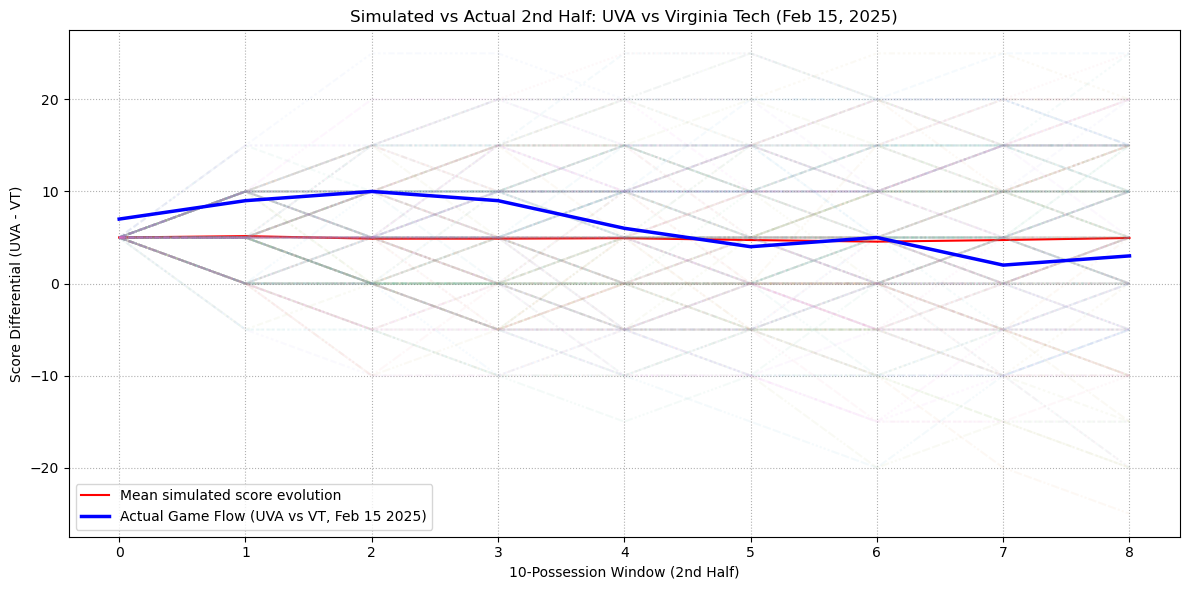

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Transition matrix setup ---
states = tr_pr.index.tolist()
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for i, s in enumerate(states)}

P = tr_pr.values  # rows sum to 1

# --- Simulation parameters ---
init_state = '[5,10)'  # starting differential of +7
init_idx = state_to_idx[init_state]
T = 8                   # 8 ten-possession windows (match 8 gameflow points)
n_sim = 200
rng = np.random.default_rng(seed=42)

# --- Simulate Markov-chain paths ---
paths = np.zeros((T + 1, n_sim), dtype=int)
paths[0, :] = init_idx

for t in range(1, T + 1):
    for sim in range(n_sim):
        current_idx = paths[t - 1, sim]
        paths[t, sim] = rng.choice(len(states), p=P[current_idx])

# --- Map to numeric score differentials ---
def extract_lower_bound(label):
    return float(label.strip('[]()').split(',')[0])

score_values = np.array([extract_lower_bound(s) for s in states])
scores = score_values[paths]

# --- Simulated mean and individual trajectories ---
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(T + 1), y=scores.mean(axis=1),
             color='red', label='Mean simulated score evolution')
sns.lineplot(data=scores, alpha=0.05, legend=False)

# --- Real Game Flow overlay (UVA vs. VT, Feb 15 2025) ---
real_times = np.arange(T + 1)  # 0..8 evenly spaced
real_diff = np.array([7, 9, 10, 9, 6, 4, 5, 2, 3])  # UVA - VT differentials

plt.plot(real_times, real_diff, color='blue',
         linewidth=2.5, label='Actual Game Flow (UVA vs VT, Feb 15 2025)')

# --- Formatting ---
plt.xlabel('10-Possession Window (2nd Half)')
plt.ylabel('Score Differential (UVA - VT)')
plt.title('Simulated vs Actual 2nd Half: UVA vs Virginia Tech (Feb 15, 2025)')
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()
